In [3]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score

Create model

In [4]:
# Define the model

def conv_batchnorm_relu(input_layer, filters, kernel_size, strides):
    conv_layer = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(input_layer)
    batchnorm_layer = tf.keras.layers.BatchNormalization()(conv_layer)
    relu_layer = tf.keras.layers.ReLU()(batchnorm_layer)
    return relu_layer

# Define the model
def create_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    # First layer
    conv1 = conv_batchnorm_relu(inputs, filters=16, kernel_size=(3, 3), strides=(1, 1))
    maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same')(conv1)
    
    # Second layer
    conv2 = conv_batchnorm_relu(maxpool1, filters=32, kernel_size=(3, 3), strides=(1, 1))
    maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(conv2)
    
    # Third layer
    conv3 = conv_batchnorm_relu(maxpool2, filters=64, kernel_size=(3, 3), strides=(1, 1))
    avgpool = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(conv3)
    
    # Flatten the output of the last convolutional layer
    flatten = tf.keras.layers.Flatten()(avgpool)
    
    # Fully connected layers
    fc1 = tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001))(flatten)
    fc2 = tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001))(fc1)

    # Output layer (binary classification)
    output = tf.keras.layers.Dense(10, activation='softmax')(fc2)
    
    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

# Example usage
input_shape = (160, 160, 1)  # Assuming input images are 32x32 RGB images


model = create_model(input_shape)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 160, 160, 16)      160       
                                                                 
 batch_normalization_3 (Bat  (None, 160, 160, 16)      64        
 chNormalization)                                                
                                                                 
 re_lu_3 (ReLU)              (None, 160, 160, 16)      0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 40, 40, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 40, 40, 32)        4640

Loading images

In [5]:
def load_images_and_separate_data(folder_path, indices_to_separate):
    images = []
    testing_images = []
    training_images = []

    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename), cv2.COLOR_BGR2GRAY)
        if img is not None:
            images.append(img)

    for idx, img in enumerate(images):
        if idx in indices_to_separate:
            testing_images.append(img)
        else:
            training_images.append(img)

    return testing_images, training_images

testing_images_persons = []
training_images_persons = []

folder_paths = [
    '.\persons\person1',
    '.\persons\person2',
    '.\persons\person3',
    '.\persons\person4',
    '.\persons\person5',
    '.\persons\person6',
    '.\persons\person7',
    '.\persons\person8',
    '.\persons\person9',
    '.\persons\person10'
]

for folder_path in folder_paths:
    testing_images, training_images = load_images_and_separate_data(folder_path,  [2, 5, 10, 11, 12, 13, 15, 39, 40, 41, 42, 44, 64])
    testing_images_persons.append(testing_images)
    training_images_persons.append(training_images)

Data augmentation

In [6]:
# Function to perform image sharpening
def sharpen_image(image):
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened

# Function to perform image flipping
def flip_image(image):
    flipped = cv2.flip(image, 1)  # 1 for horizontal flipping
    return flipped

# Perform data augmentation for all persons
augmented_training_images_persons = []
for i in range(10):
    augmented_training_images_person = []
    training_images_person = training_images_persons[i]
    for image in training_images_person:
        sharpened_image = sharpen_image(image)
        flipped_image = flip_image(image)
        augmented_training_images_person.append(sharpened_image)
        augmented_training_images_person.append(flipped_image)
    augmented_training_images_persons.append(np.array(augmented_training_images_person))

Prepare data to feeding

In [10]:
# Concatenate the training arrays and label corresponding indices
augmented_training_images = np.concatenate(augmented_training_images_persons)
y_train = np.concatenate([np.full(len(augmented_training_images_persons[i]), i) for i in range(10)])

# Shuffle the data
shuffle_indices = np.random.permutation(len(augmented_training_images))
X_train_shuffled = augmented_training_images[shuffle_indices]
y_train_shuffled = y_train[shuffle_indices]
y_train_one_hot = tf.keras.utils.to_categorical(y_train_shuffled, num_classes=10)

Compile and train model

Epoch 1/100
42/42 [==============================] - 10s 167ms/step - loss: 2.4574 - accuracy: 0.2785 - val_loss: 4.8131 - val_accuracy: 0.1627
Epoch 2/100
42/42 [==============================] - 7s 155ms/step - loss: 1.1956 - accuracy: 0.7311 - val_loss: 3.1846 - val_accuracy: 0.3062
Epoch 3/100
42/42 [==============================] - 7s 158ms/step - loss: 0.6183 - accuracy: 0.9064 - val_loss: 1.7123 - val_accuracy: 0.6220
Epoch 4/100
42/42 [==============================] - 7s 157ms/step - loss: 0.3990 - accuracy: 0.9664 - val_loss: 0.5547 - val_accuracy: 0.8900
Epoch 5/100
42/42 [==============================] - 7s 159ms/step - loss: 0.3114 - accuracy: 0.9868 - val_loss: 0.4514 - val_accuracy: 0.9187
Epoch 6/100
42/42 [==============================] - 7s 159ms/step - loss: 0.2797 - accuracy: 0.9808 - val_loss: 0.3442 - val_accuracy: 0.9617
Epoch 7/100
42/42 [==============================] - 7s 159ms/step - loss: 0.2585 - accuracy: 0.9808 - val_loss: 0.2889 - val_accuracy: 0.971

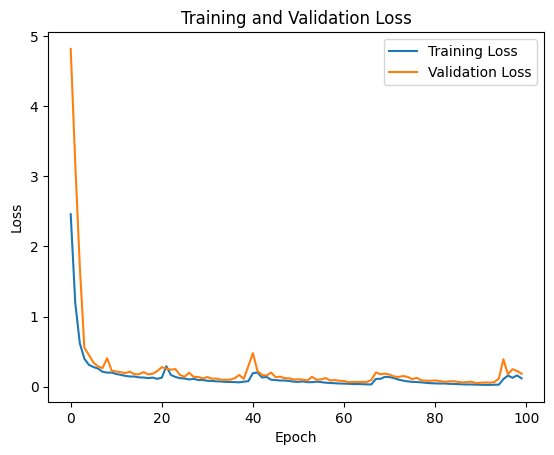

In [8]:
import matplotlib.pyplot as plt

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
history=model.fit(X_train_shuffled, y_train_one_hot, epochs=100, batch_size=20, validation_split=0.2)

# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Prepare test data to feeding 

In [11]:
# Convert testing images for all persons to numpy arrays and concatenate
testing_images_persons_np = [np.array(testing_images_person) for testing_images_person in testing_images_persons]
X_test = np.concatenate(testing_images_persons_np)

# Create labels for y_test
y_test = np.concatenate([np.full(len(testing_images_person), i) for i, testing_images_person in enumerate(testing_images_persons_np)])

# Shuffle the data
shuffle_indices2 = np.random.permutation(len(X_test))
X_test_shuffled = X_test[shuffle_indices2]
y_test_shuffled = y_test[shuffle_indices2]

# Convert y_test to one-hot encoding
y_test_one_hot = tf.keras.utils.to_categorical(y_test_shuffled, num_classes=10)

Test the model with testing data

In [12]:

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_shuffled, y_test_one_hot, verbose=0)

# Predict probabilities for the test data
y_pred_proba = model.predict(X_test_shuffled)

# Convert probabilities to binary predictions
y_pred_binary = np.argmax(y_pred_proba, axis=1)

# Calculate F1 score
f1 = f1_score(np.argmax(y_test_one_hot, axis=1), y_pred_binary, average='weighted')

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

5/5 [==============================] - 0s 52ms/step
Loss: 0.12656104564666748
Accuracy: 0.9769230484962463
F1 Score: 0.976888888888889
